Data Source : https://www.kaggle.com/kyanyoga/sample-sales-data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sales_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MarketingAI/sales_data_sample.csv', encoding = 'unicode_escape')


In [4]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,...,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [5]:
# Let's view the types of data
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [6]:
# Convert order date to datetime format
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [7]:
# Check the number of non-null values in the dataframe
sales_df.info()

# Check the number of Null values in the data
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [8]:
df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['QUANTITYORDERED'].plot(kind='hist', bins=20, title='QUANTITYORDERED')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['PRICEEACH'].plot(kind='hist', bins=20, title='PRICEEACH')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['ORDERLINENUMBER'].plot(kind='hist', bins=20, title='ORDERLINENUMBER')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('COUNTRY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('DEALSIZE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='index', y='QUANTITYORDERED', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='QUANTITYORDERED', y='PRICEEACH', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='PRICEEACH', y='ORDERLINENUMBER', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='ORDERLINENUMBER', y='SALES', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDERDATE']
  ys = series['PRICEEACH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('ORDERDATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('COUNTRY')):
  _plot_series(series, series_name, i)
  fig.legend(title='COUNTRY', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDERDATE')
_ = plt.ylabel('PRICEEACH')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDERDATE']
  ys = series['PRICEEACH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('ORDERDATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('DEALSIZE')):
  _plot_series(series, series_name, i)
  fig.legend(title='DEALSIZE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDERDATE')
_ = plt.ylabel('PRICEEACH')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDERDATE']
  ys = series['ORDERLINENUMBER']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('ORDERDATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('COUNTRY')):
  _plot_series(series, series_name, i)
  fig.legend(title='COUNTRY', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDERDATE')
_ = plt.ylabel('ORDERLINENUMBER')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDERDATE']
  ys = series['ORDERLINENUMBER']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('ORDERDATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('DEALSIZE')):
  _plot_series(series, series_name, i)
  fig.legend(title='DEALSIZE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDERDATE')
_ = plt.ylabel('ORDERLINENUMBER')

from matplotlib import pyplot as plt
_df_14['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['QUANTITYORDERED'].plot(kind='line', figsize=(8, 4), title='QUANTITYORDERED')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['PRICEEACH'].plot(kind='line', figsize=(8, 4), title='PRICEEACH')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['ORDERLINENUMBER'].plot(kind='line', figsize=(8, 4), title='ORDERLINENUMBER')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['DEALSIZE'].value_counts()
    for x_label, grp in _df_18.groupby('COUNTRY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('COUNTRY')
_ = plt.ylabel('DEALSIZE')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['COUNTRY'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='COUNTRY', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['DEALSIZE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='DEALSIZE', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['COUNTRY'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='QUANTITYORDERED', y='COUNTRY', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['DEALSIZE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='QUANTITYORDERED', y='DEALSIZE', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [9]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [10]:
# Obtain the number of unique values in each column
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

# EDA


In [11]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [12]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [13]:
# Function to visualize the count of items in a given column

def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 500)
  fig.show()

In [14]:
barplot_visualization('COUNTRY')

In [15]:
barplot_visualization('STATUS')

In [16]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [17]:
barplot_visualization('PRODUCTLINE')

In [18]:
barplot_visualization('DEALSIZE')

In [19]:
# Function to add dummy variables to replace categorical variables

def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [20]:
# Let's obtain dummy variables for the column 'COUNTRY'
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,...,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,...,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,...,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,...,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,...,0,0,0,0,0,0,0,0,0,0


In [21]:
sales_df = dummies('PRODUCTLINE')

In [22]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,0,0,0,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,0,0,0,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,0,0,0,0,0,0,1,0,0,0


In [23]:
sales_df = dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,0,0,0,1,0,0,0,0,0,1


In [24]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [25]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [27]:
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [28]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,0,1


In [29]:
# Group data by order date
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37,0,...,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723,0,...,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720,0,...,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101,0,...,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462,0,...,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797,13,...,7,0,0,0,0,0,8,0,8,7


In [30]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [31]:
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

<Axes: >

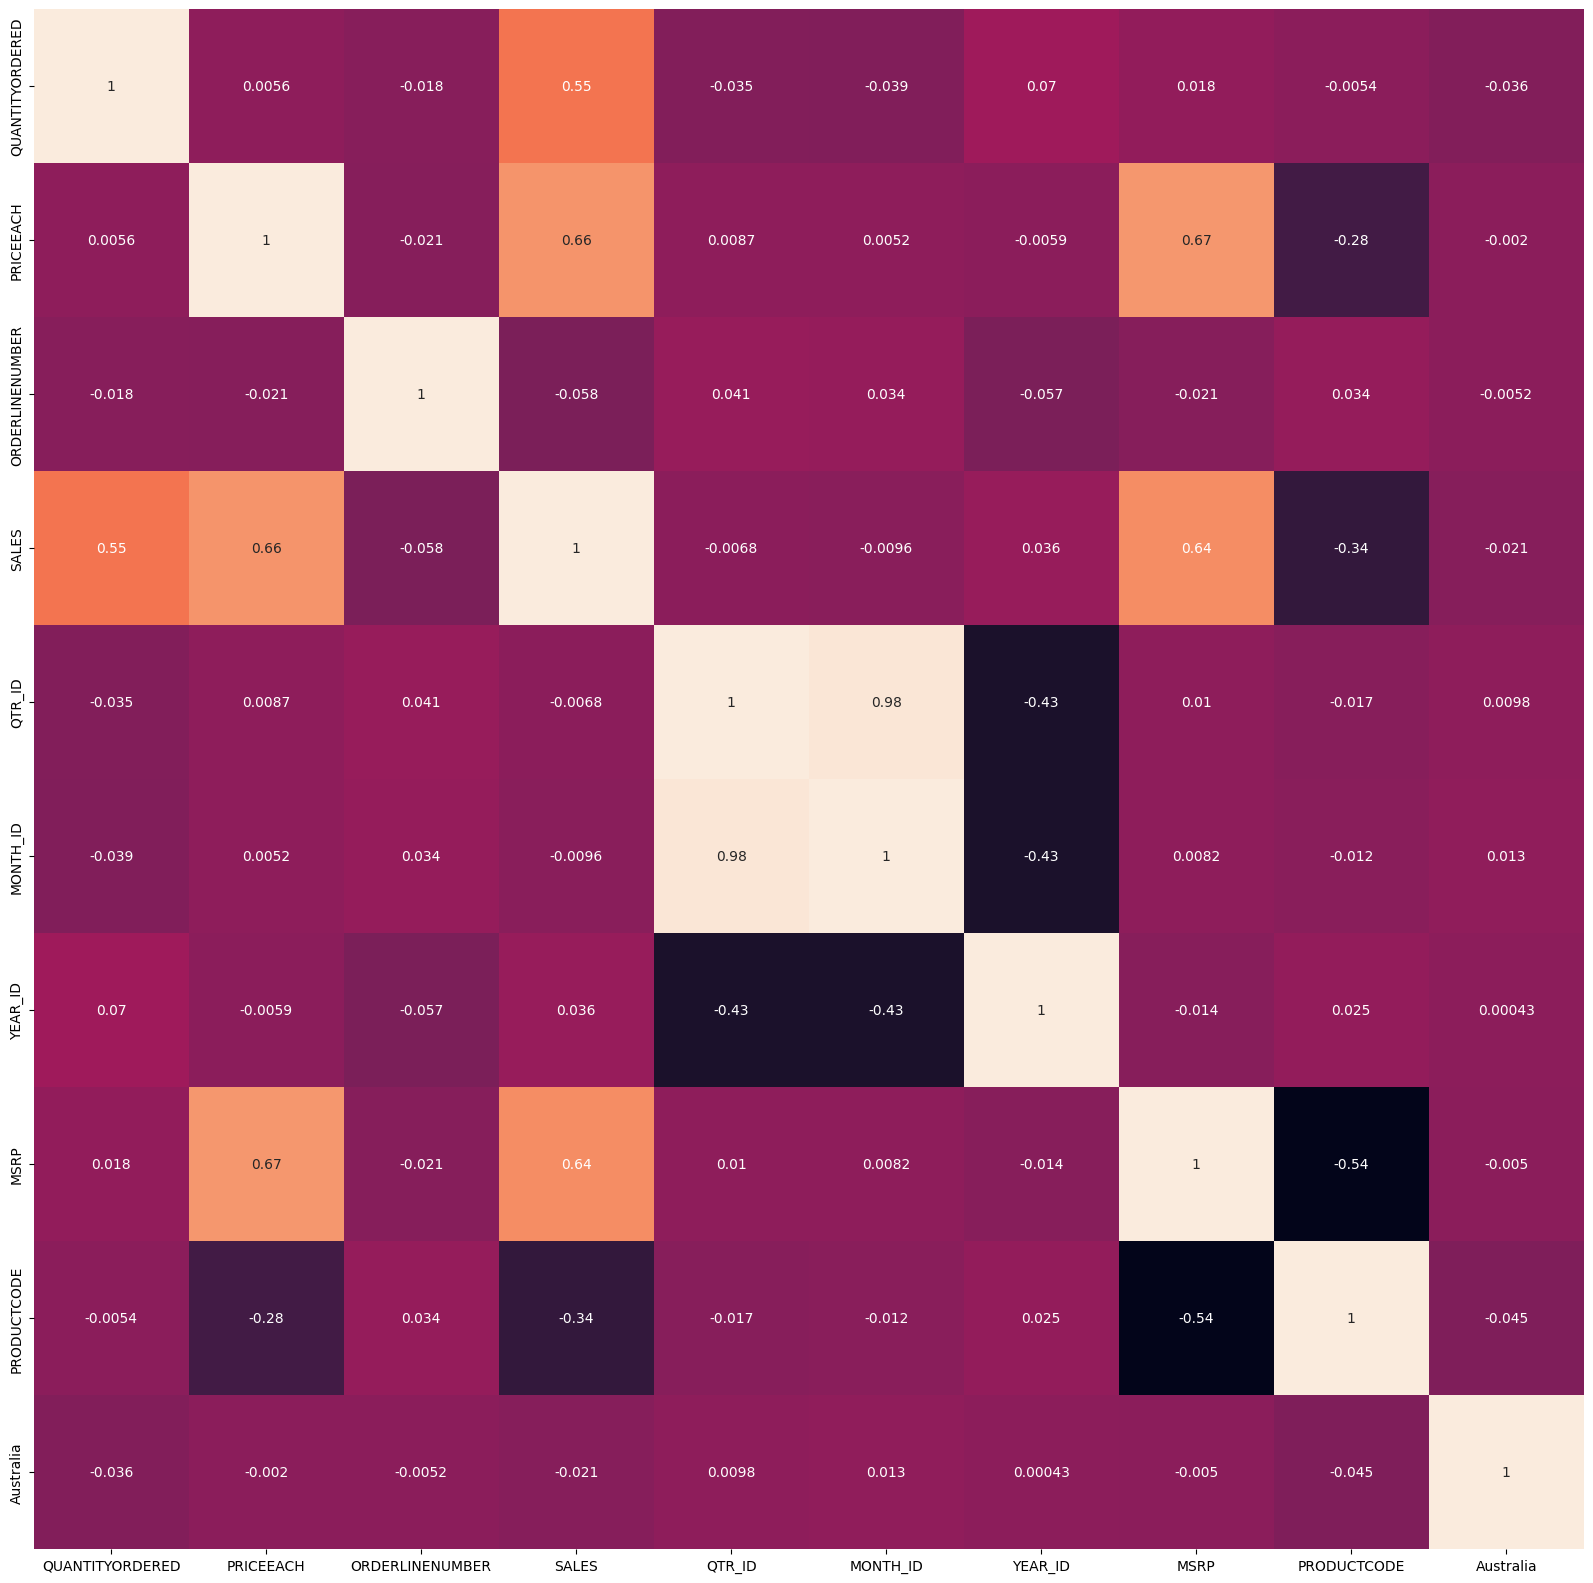

In [32]:
#Correlation matrix
plt.figure(figsize = (20, 20))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [33]:
# 'QTR_ID' and the 'MONTH_ID' are highly correlated drop any one from them.
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [34]:
# Let's plot distplots
import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()


<Figure size 1000x1000 with 0 Axes>

In [35]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()




<Figure size 1500x1500 with 0 Axes>

## A trend exists between 'SALES' and 'QUANTITYORDERED', 'MSRP' and 'PRICEEACH', 'PRICEEACH' and 'SALES'
## It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')


#OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

In [36]:
# Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [37]:
sales_df_scaled.shape

(2823, 37)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

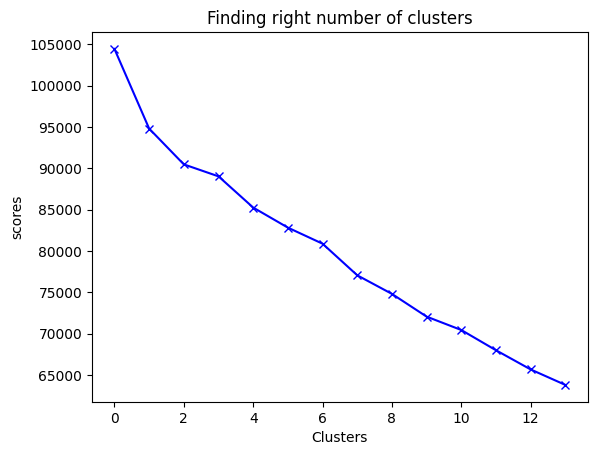

In [38]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()



#K-MEANS METHOD

In [39]:
# Cluster the data using k-means
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [40]:
labels

array([0, 0, 2, ..., 2, 0, 2], dtype=int32)

In [41]:
kmeans.cluster_centers_.shape

(5, 37)

In [42]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.452498,-0.769647,0.031762,-0.821178,0.019338,-0.030481,-0.596494,0.191776,0.024088,-0.021591,...,-0.078639,0.079998,-0.348674,0.108264,0.113905,-0.003941,0.177175,-0.242672,-0.980703,1.096370
1,1.264271,0.800092,-0.261504,2.581716,-0.085287,0.144435,1.412341,-0.861488,-0.082322,0.045752,...,0.569706,0.016566,-0.161898,-0.300637,-0.127846,-0.199144,-0.146484,4.120788,-0.980703,-0.912100
2,0.259248,0.605477,-0.042492,0.475977,-0.008456,-0.026202,0.431195,-0.259456,-0.019414,0.023075,...,0.168848,0.020625,-0.325232,-0.004023,-0.043178,0.095285,-0.016849,-0.242672,1.018057,-0.910474
3,0.010285,0.152186,-0.131095,0.070903,0.473773,0.013539,0.101390,-0.164484,-0.264819,-0.140961,...,-0.093345,-0.200857,-0.179374,0.335664,-0.059748,0.279807,-0.010937,-0.089568,0.107222,-0.066429
4,-0.080859,-0.143043,0.230985,-0.337311,-0.085752,0.148965,-0.373481,0.891602,0.089654,-0.014029,...,-0.721812,-0.364452,2.868012,-0.300637,-0.167454,-0.345470,-0.523371,-0.242672,-0.145457,0.257746


In [43]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30.685610,68.134216,6.600367,2041.657113,7.163153,2003.793767,76.747938,59.829514,7.149404e-02,1.649863e-02,...,3.052246e-01,1.429881e-01,6.522560e-16,1.127406e-01,4.582951e-02,1.054079e-01,2.878093e-01,5.828671e-16,-1.054712e-15,1.000000e+00
1,47.406452,99.796968,5.361290,8308.219097,6.780645,2003.916129,157.464516,26.567742,4.516129e-02,2.580645e-02,...,6.129032e-01,1.225806e-01,5.806452e-02,-6.938894e-17,6.451613e-03,4.516129e-02,1.548387e-01,1.000000e+00,-7.216450e-16,1.332268e-15
2,37.617814,95.871433,6.286640,4430.419587,7.061538,2003.796761,118.041296,45.579757,6.072874e-02,2.267206e-02,...,4.226721e-01,1.238866e-01,7.287449e-03,8.178138e-02,2.024291e-02,1.360324e-01,2.080972e-01,6.730727e-16,9.991903e-01,8.097166e-04
3,35.192982,86.728246,5.912281,3684.459825,8.824561,2003.824561,104.789474,48.578947,1.387779e-17,1.040834e-17,...,2.982456e-01,5.263158e-02,5.263158e-02,1.754386e-01,1.754386e-02,1.929825e-01,2.105263e-01,3.508772e-02,5.438596e-01,4.210526e-01
4,34.305263,80.773263,7.442105,2932.717825,6.778947,2003.919298,85.708772,81.929825,8.771930e-02,1.754386e-02,...,1.665335e-16,-3.469447e-16,1.000000e+00,0.000000e+00,-1.006140e-16,1.387779e-17,4.996004e-16,-1.457168e-16,4.175439e-01,5.824561e-01



# Cluster 0 (Highest) - This group represents customers who buy items in high quantity centered around ~47, they buy items in all price range leaning towards high price items of ~99. They also correspond to the highest total sales around ~8296 and they are active throughout the year. They are the highest buyers of products with high MSRP ~158.
# Cluster 1 - This group represents customers who buy items in varying quantity ~35, they tend to buy high price items ~96. Their sales is bit better average ~4435, they buy products with second highest MSRP of ~133.
# Cluster 2 (lowest) - This group represents customers who buy items in low quantity ~30. They tend to buy low price items ~68. Their sales ~2044 is lower than other clusters and they are extremely active around holiday season. They buy products with low MSRP ~75.
# Cluster 3 - This group represents customers who are only active during the holidays. they buy in lower quantity ~35, but they tend to buy average price items around ~86. They also correspond to lower total sales around ~3673, they tend to buy items with MSRP around 102.
# Cluster 4 - This group represents customers who buy items in varying quantity ~39, they tend to buy average price items ~94. Their sales ~4280.




In [44]:
labels.shape # Labels associated to each data pointa

(2823,)

In [45]:
labels.max()

4

In [46]:
labels.min()

0

In [47]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([2, 2, 3, ..., 4, 4, 4], dtype=int32)

In [48]:
y_kmeans.shape

(2823,)

In [49]:
# Add a label (which cluster) corresponding to each data point
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,34,81.35,5,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,41,94.74,2,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
3,45,83.26,6,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
4,49,100.00,14,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,...,0,0,1,0,0,0,0,0,1,0
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,2
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,2
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,0,1,0


In [50]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

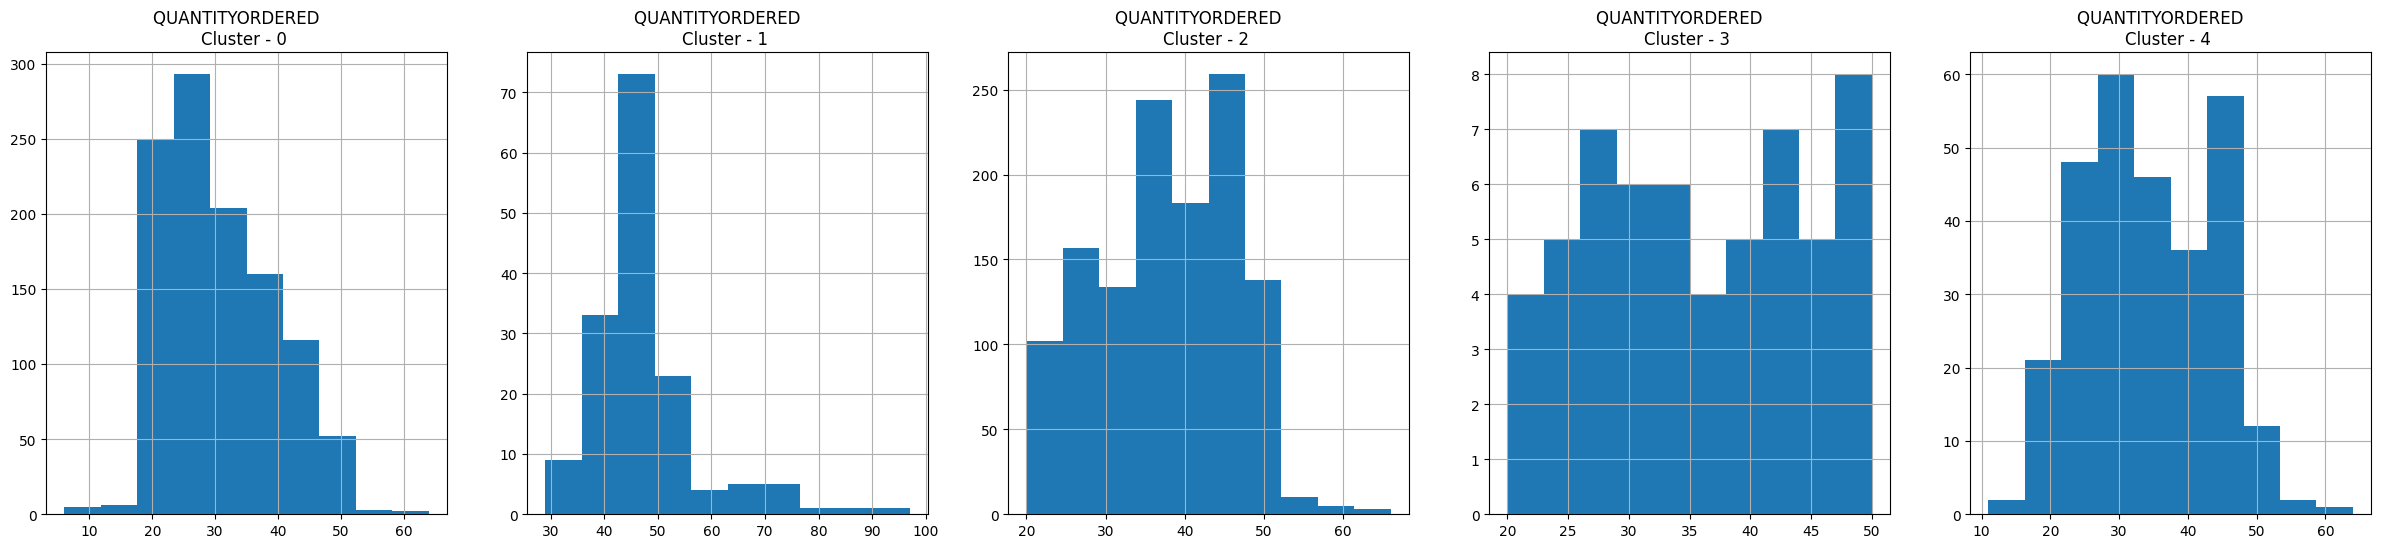

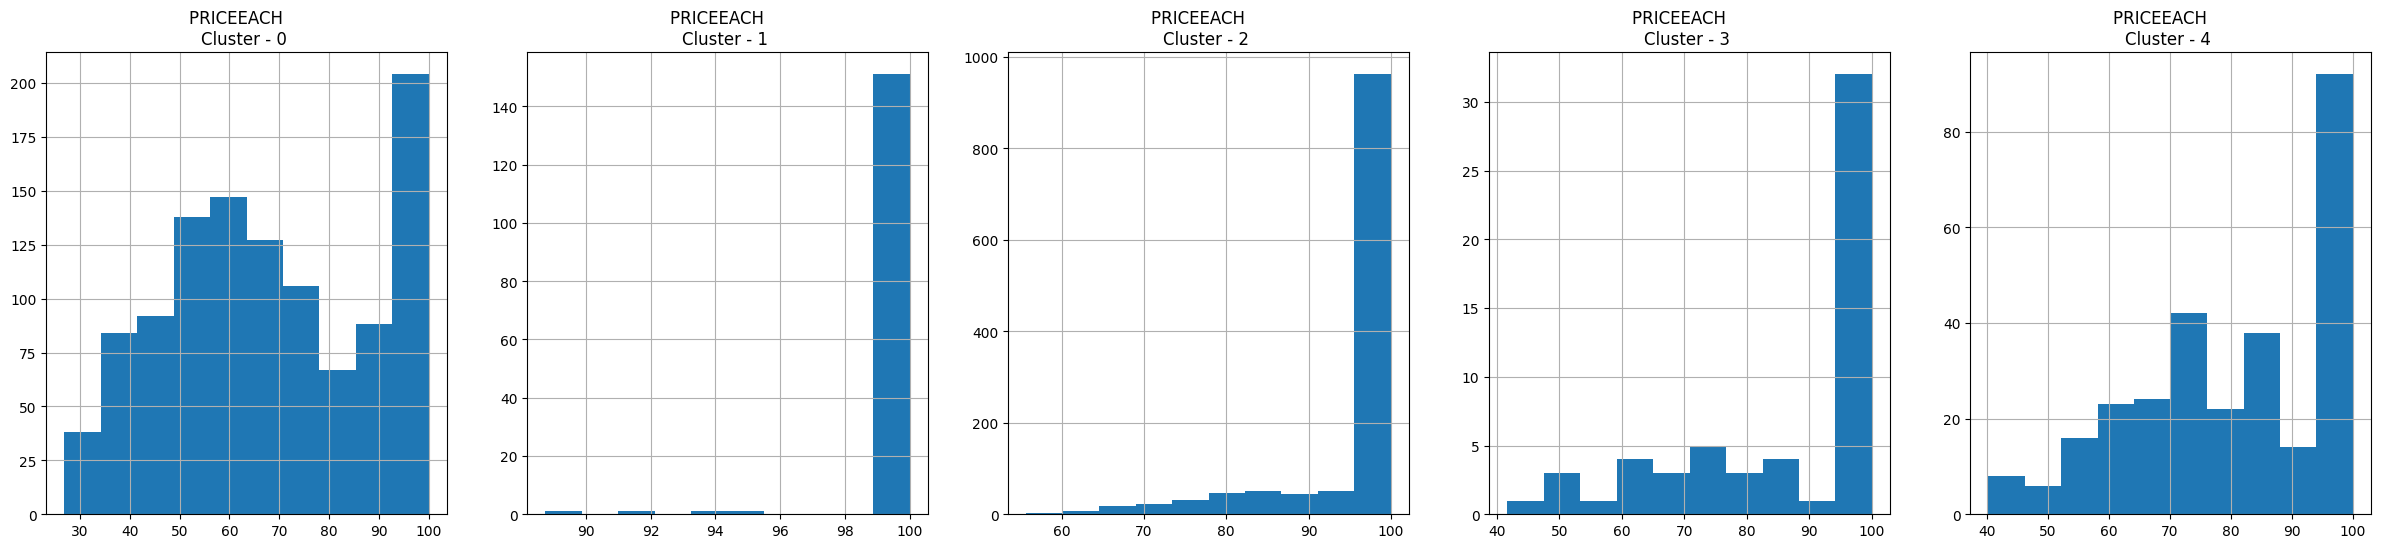

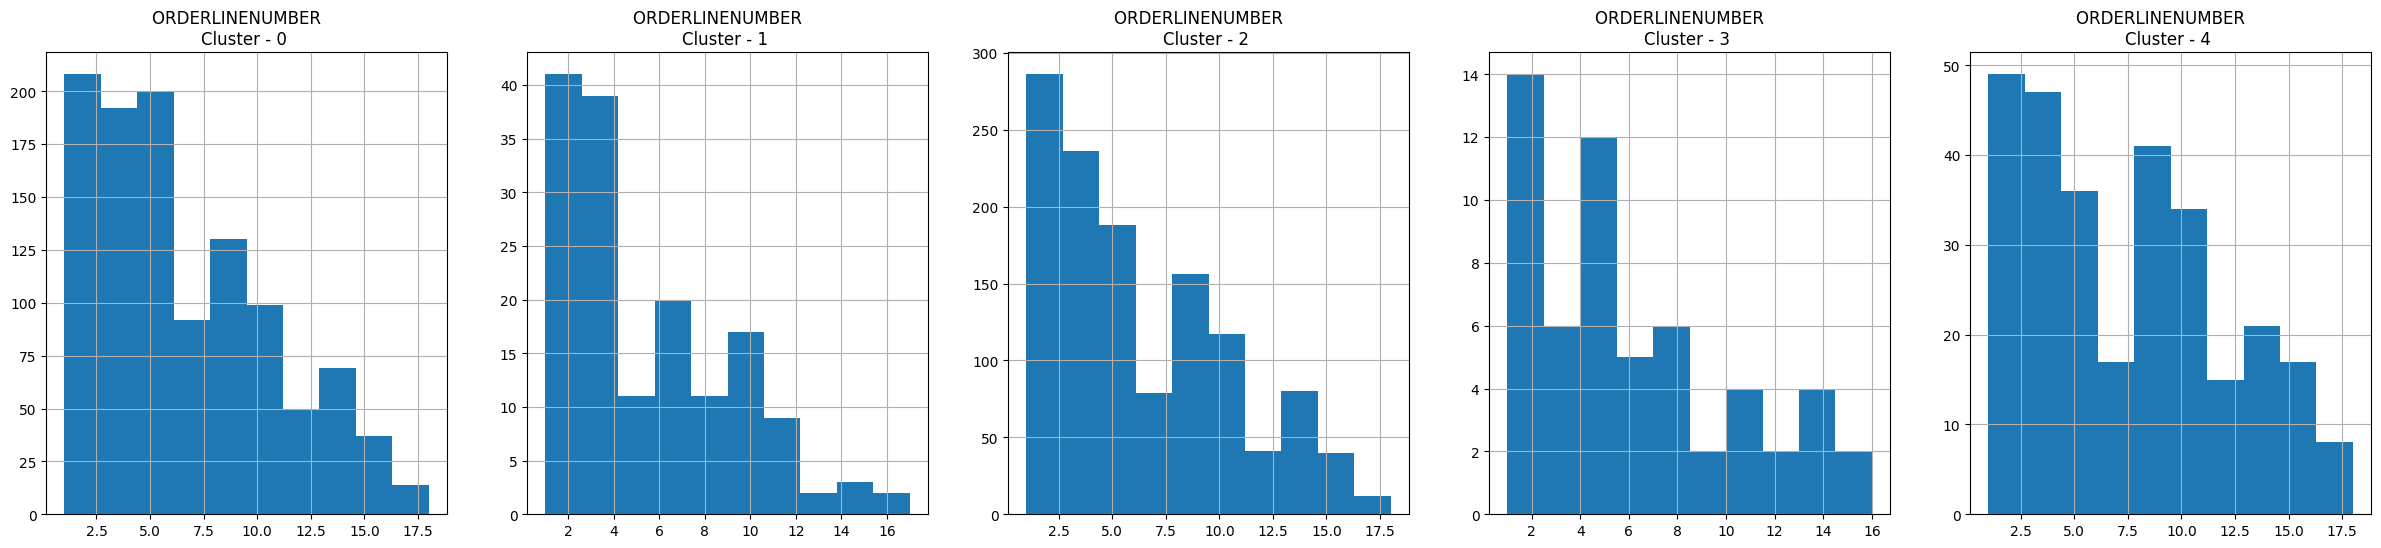

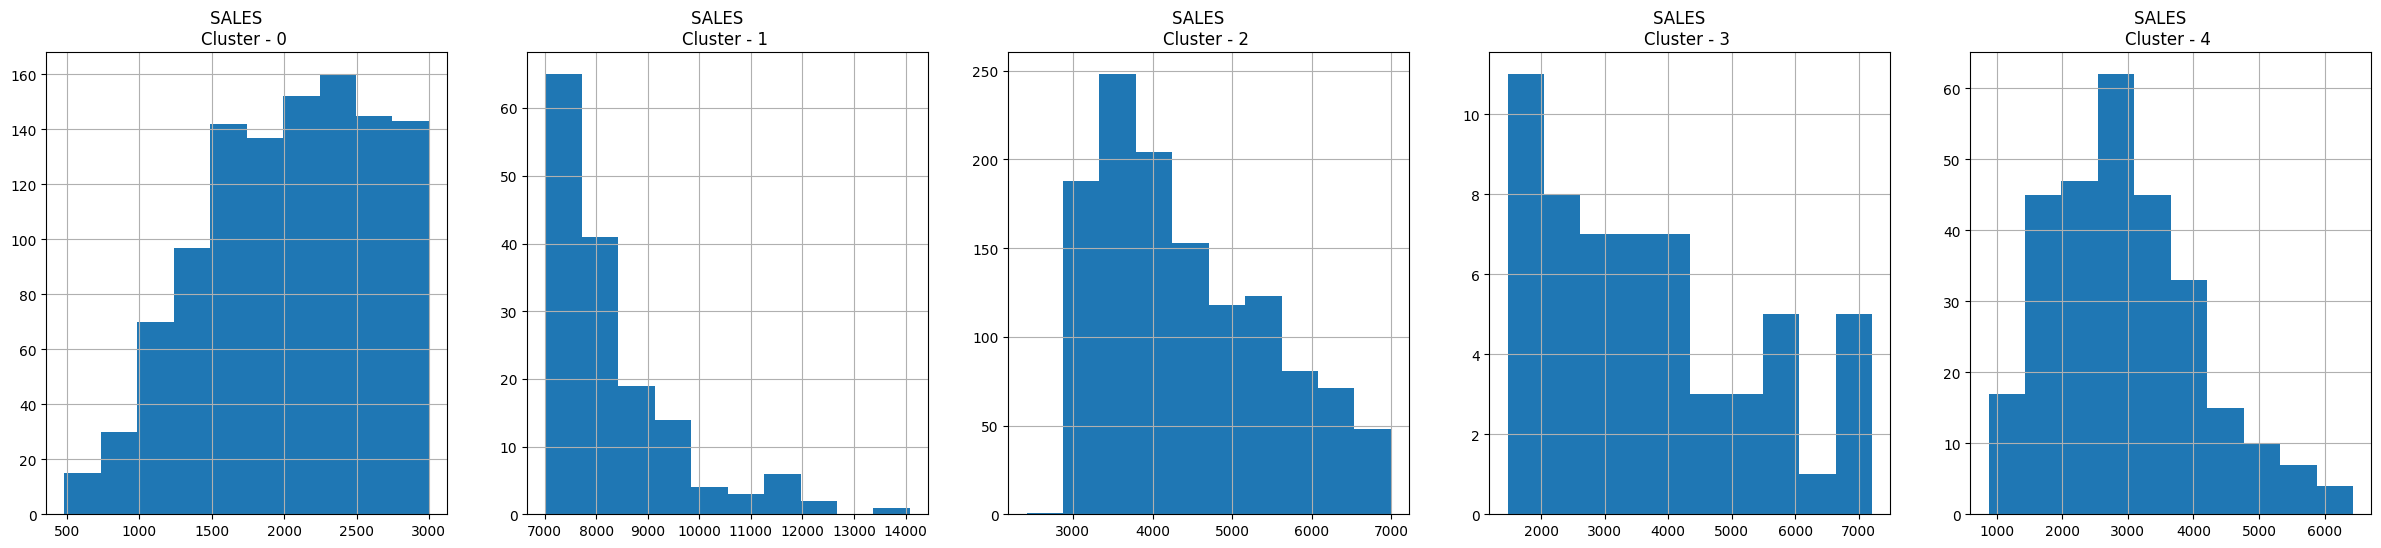

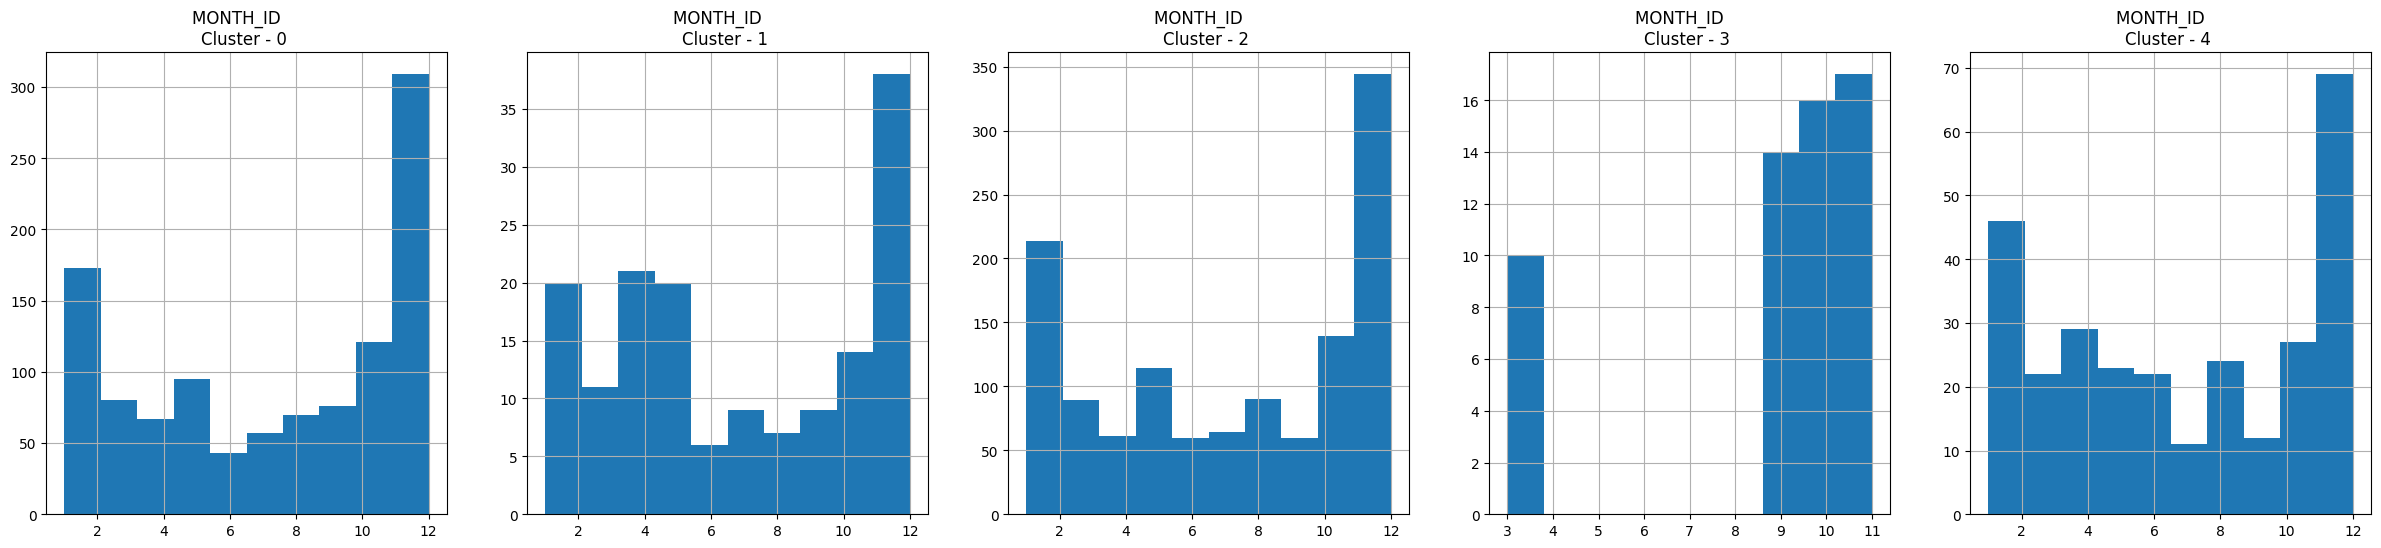

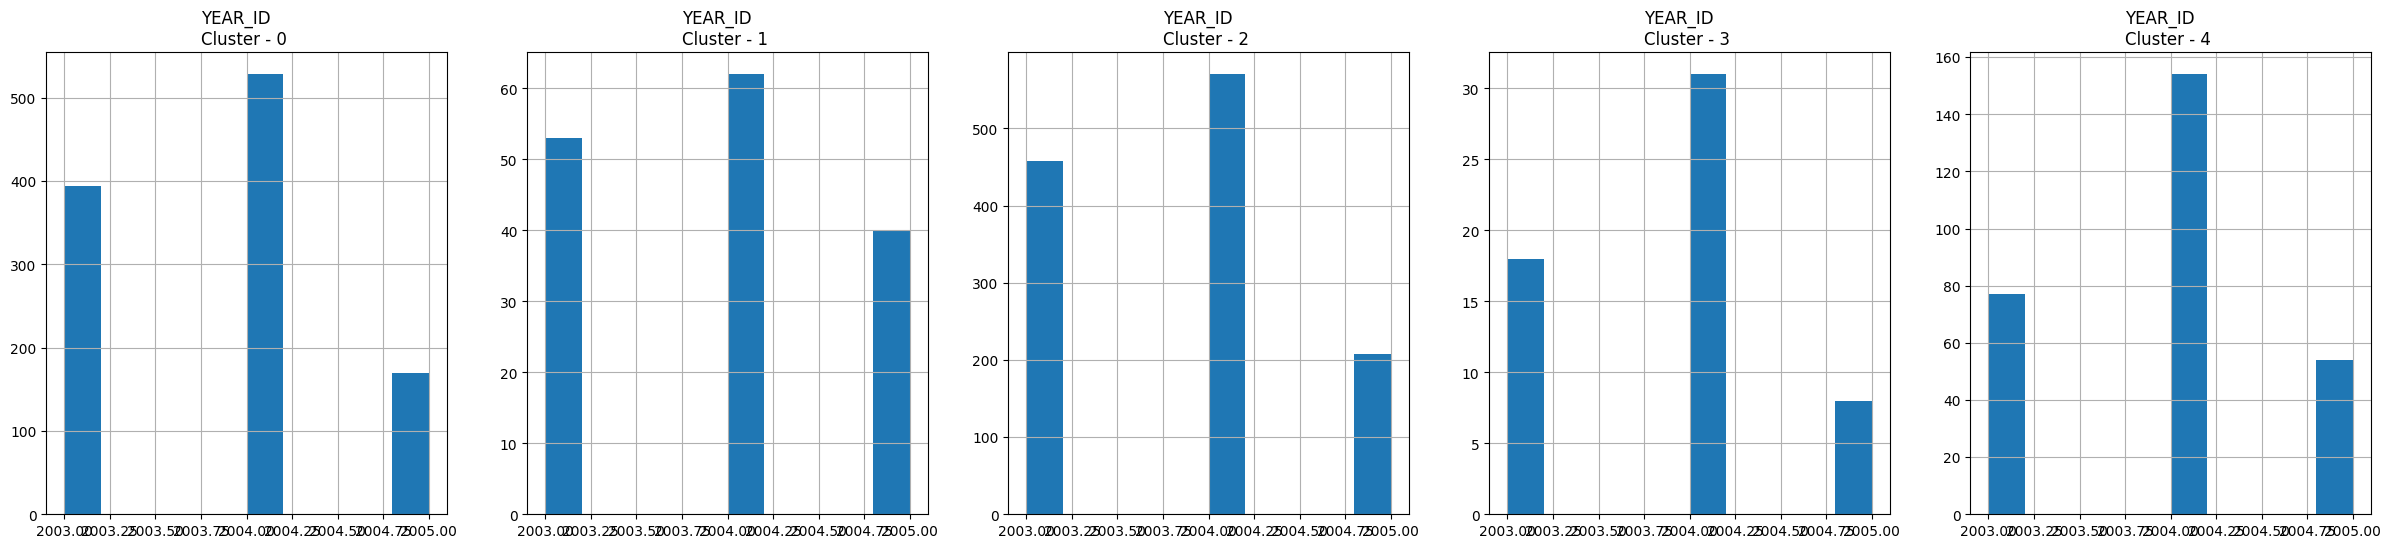

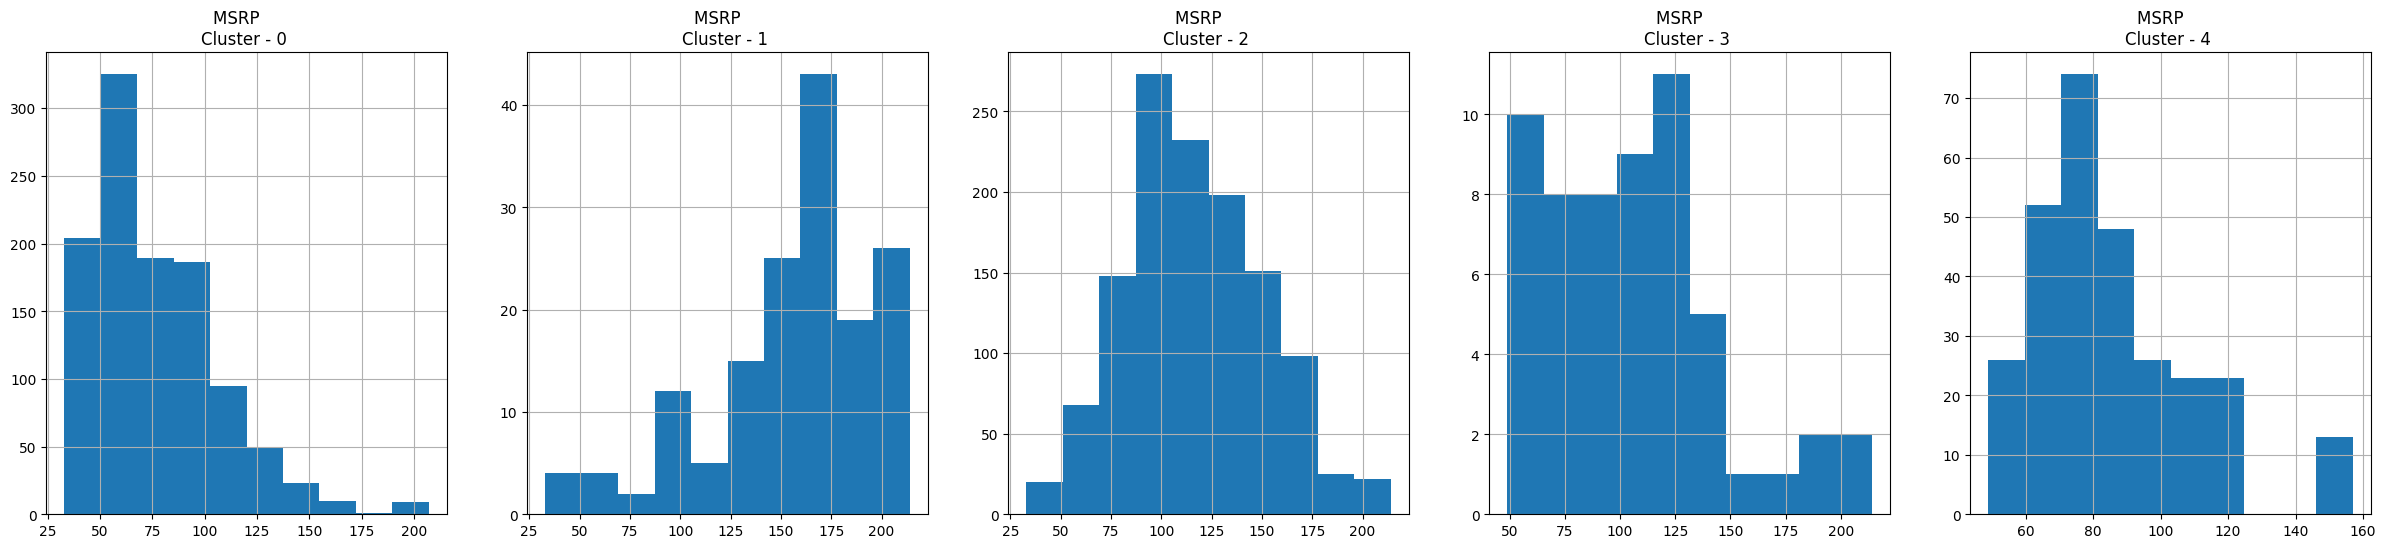

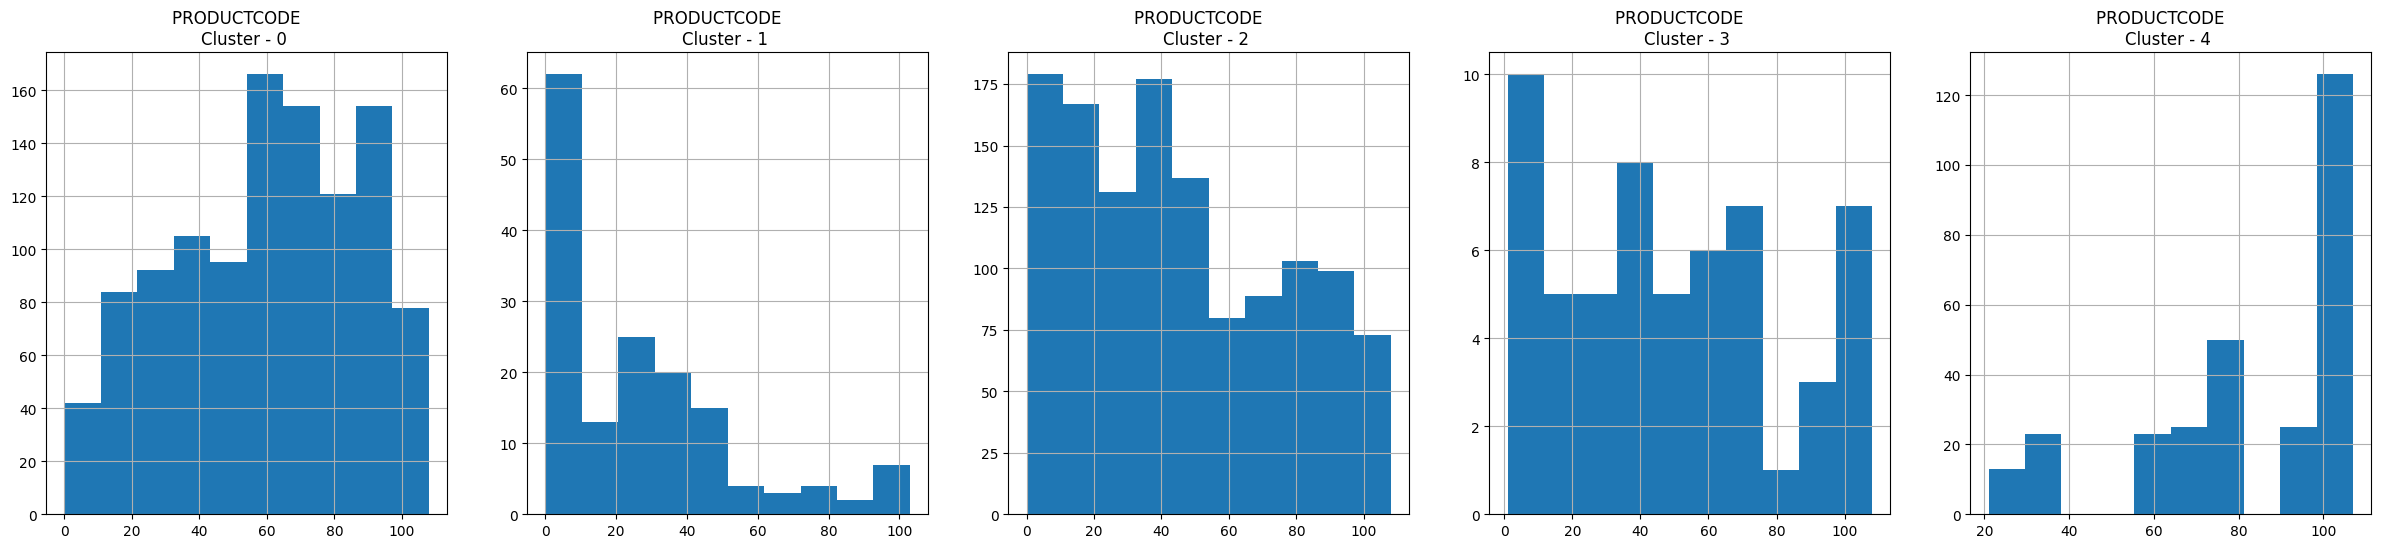

In [51]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()


In [52]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48627823, -1.23352648,  1.02491849],
       [-0.78459024, -1.05860524,  1.42654061],
       [ 1.43150206,  0.10588454,  0.30477797],
       ...,
       [ 0.38990849,  4.10247864, -0.05597863],
       [-2.78879218,  2.37144578,  1.51406176],
       [-0.70549225,  3.31207237, -0.54472327]])

In [53]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca2'])
pca_df.head()

,pca1,pca2,pca2
0,-0.486278,-1.233526,1.024918
1,-0.784590,-1.058605,1.426541
2,1.431502,0.105885,0.304778
3,1.288422,-0.234982,-0.550080
4,1.976016,-0.160758,-1.041206


In [54]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca2,cluster
0,-0.486278,-1.233526,1.024918,0
1,-0.784590,-1.058605,1.426541,0
2,1.431502,0.105885,0.304778,2
3,1.288422,-0.234982,-0.550080,2
4,1.976016,-0.160758,-1.041206,2
...,...,...,...,...
2818,-2.450209,1.049490,-1.535709,0
2819,-0.158370,3.696304,0.654344,2
2820,0.389908,4.102479,-0.055979,2
2821,-2.788792,2.371446,1.514062,0


# Auto Encoders

In [58]:
sales_df.shape

(2823, 37)

In [59]:
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [61]:
autoencoder.fit(sales_df, sales_df, batch_size = 150, epochs = 750, verbose = 3)

Epoch 1/750
Epoch 2/750
Epoch 3/750
Epoch 4/750
Epoch 5/750
Epoch 6/750
Epoch 7/750
Epoch 8/750
Epoch 9/750
Epoch 10/750
Epoch 11/750
Epoch 12/750
Epoch 13/750
Epoch 14/750
Epoch 15/750
Epoch 16/750
Epoch 17/750
Epoch 18/750
Epoch 19/750
Epoch 20/750
Epoch 21/750
Epoch 22/750
Epoch 23/750
Epoch 24/750
Epoch 25/750
Epoch 26/750
Epoch 27/750
Epoch 28/750
Epoch 29/750
Epoch 30/750
Epoch 31/750
Epoch 32/750
Epoch 33/750
Epoch 34/750
Epoch 35/750
Epoch 36/750
Epoch 37/750
Epoch 38/750
Epoch 39/750
Epoch 40/750
Epoch 41/750
Epoch 42/750
Epoch 43/750
Epoch 44/750
Epoch 45/750
Epoch 46/750
Epoch 47/750
Epoch 48/750
Epoch 49/750
Epoch 50/750
Epoch 51/750
Epoch 52/750
Epoch 53/750
Epoch 54/750
Epoch 55/750
Epoch 56/750
Epoch 57/750
Epoch 58/750
Epoch 59/750
Epoch 60/750
Epoch 61/750
Epoch 62/750
Epoch 63/750
Epoch 64/750
Epoch 65/750
Epoch 66/750
Epoch 67/750
Epoch 68/750
Epoch 69/750
Epoch 70/750
Epoch 71/750
Epoch 72/750
Epoch 73/750
Epoch 74/750
Epoch 75/750
Epoch 76/750
Epoch 77/750
Epoch 78

In [62]:
autoencoder.save_weights('autoencoder_1.h5')

In [63]:
pred = encoder.predict(sales_df_scaled)

89/89 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

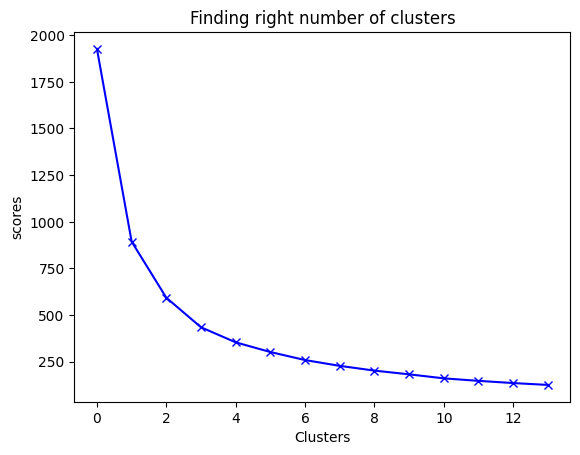

In [64]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()

In [65]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [66]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
1,34,81.35,5.0,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2.0,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
3,45,83.26,6.0,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
4,49,100.00,14.0,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2


In [67]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,0.438987,0.503532,-0.031271,0.368452,-0.034690,0.050901,0.038997,0.120578,0.017313,-0.071019,...,-0.520371,0.122994,0.093577,0.116205,0.003997,0.260086,0.159003,-0.237985,1.017528,-0.912100
1,0.294868,0.741988,-0.043578,1.103251,0.030381,-0.049520,1.179026,-0.796343,-0.077016,0.148908,...,1.142262,-0.219995,-0.297124,-0.300637,-0.157615,-0.303931,-0.429753,0.848193,0.474701,-0.867039
2,-0.467425,-0.734849,0.044405,-0.813453,0.010520,-0.013004,-0.608847,0.303360,0.025189,-0.021136,...,-0.180052,0.017957,0.077512,0.062627,0.074630,-0.041394,0.094743,-0.242672,-0.980703,1.096370


In [68]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,39.368421,93.815134,6.334049,4232.408271,6.965628,2003.850698,102.282492,57.581096,0.069817,0.009667,...,0.095596,0.156821,0.137487,1.149302e-01,0.027927,0.186896,0.280344,1.074114e-03,9.989259e-01,3.497203e-15
1,37.964744,98.624968,6.282051,5585.569311,7.203526,2003.780449,148.089744,28.625000,0.046474,0.040064,...,0.884615,0.046474,0.016026,9.298118e-16,0.001603,0.012821,0.038462,2.500000e-01,7.275641e-01,2.243590e-02
2,30.540221,68.836120,6.653785,2055.884464,7.130915,2003.805994,76.251577,63.353312,0.071767,0.016562,...,0.257098,0.123028,0.132492,1.001577e-01,0.039432,0.093849,0.253943,6.800116e-16,-1.054712e-15,1.000000e+00


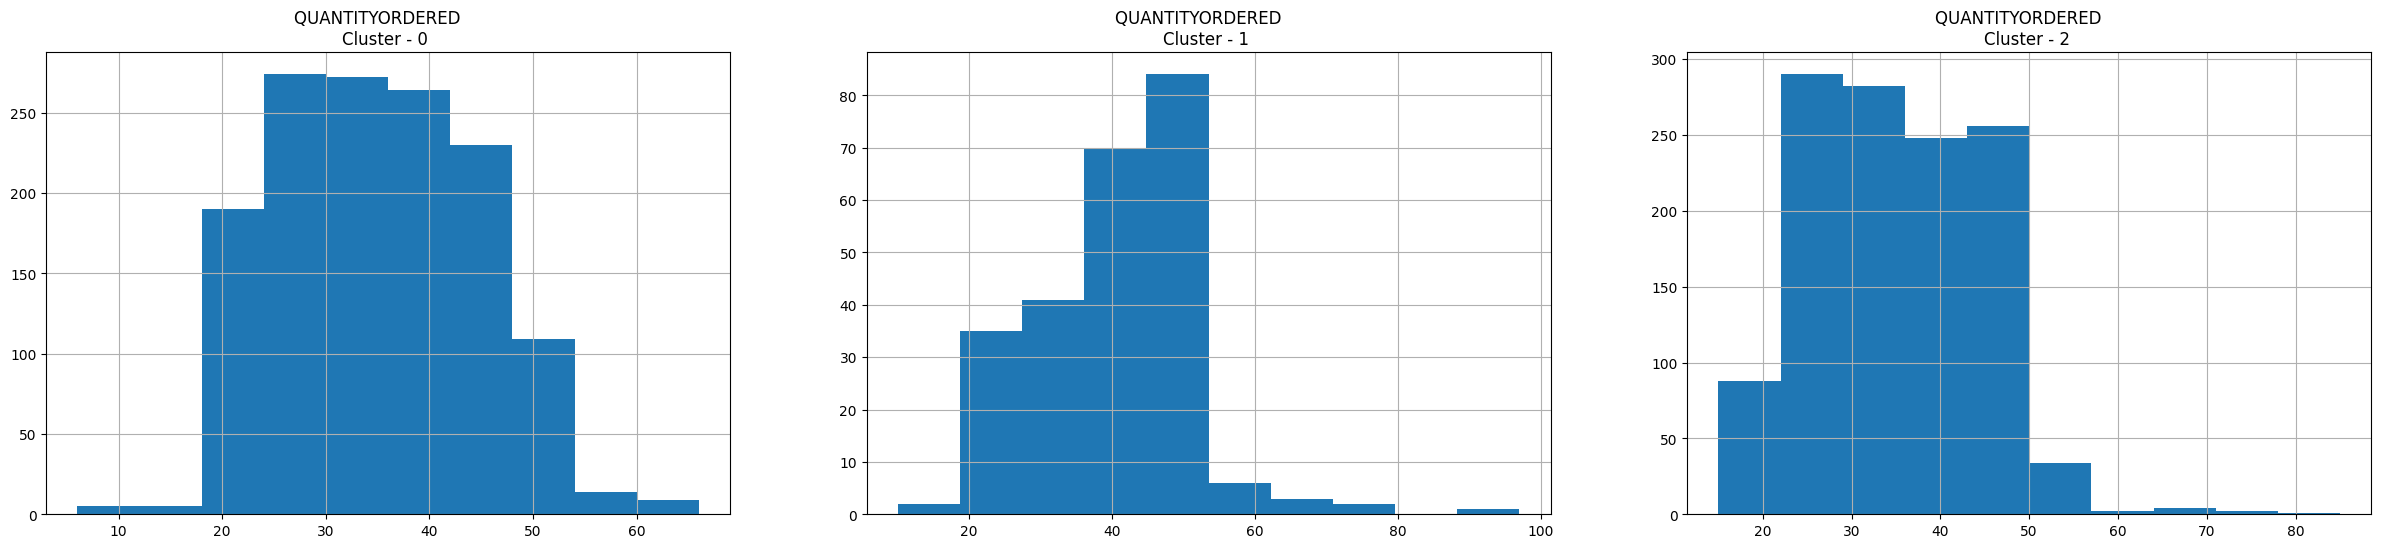

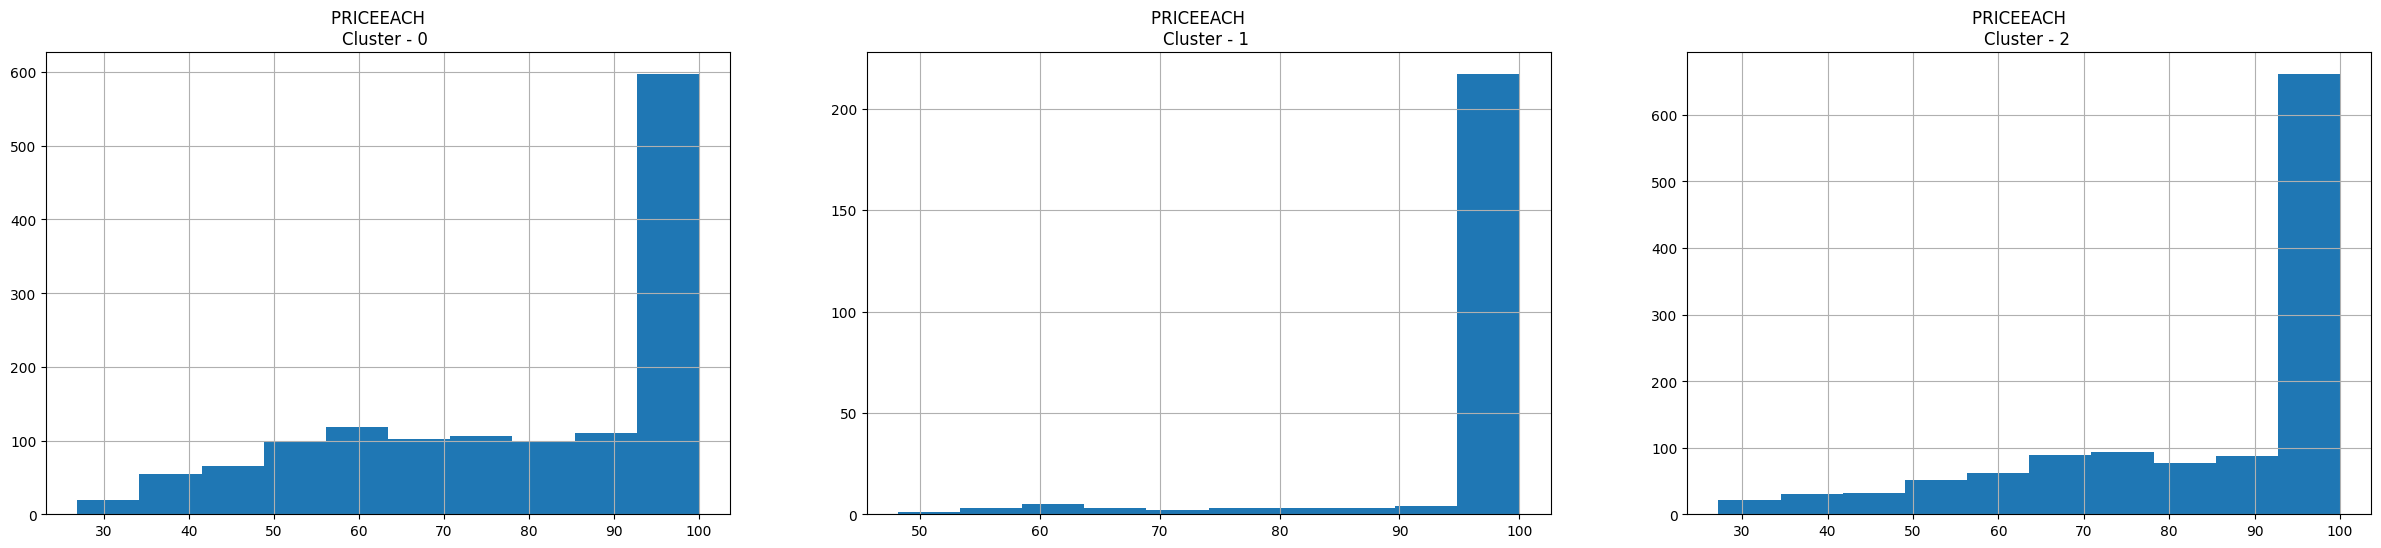

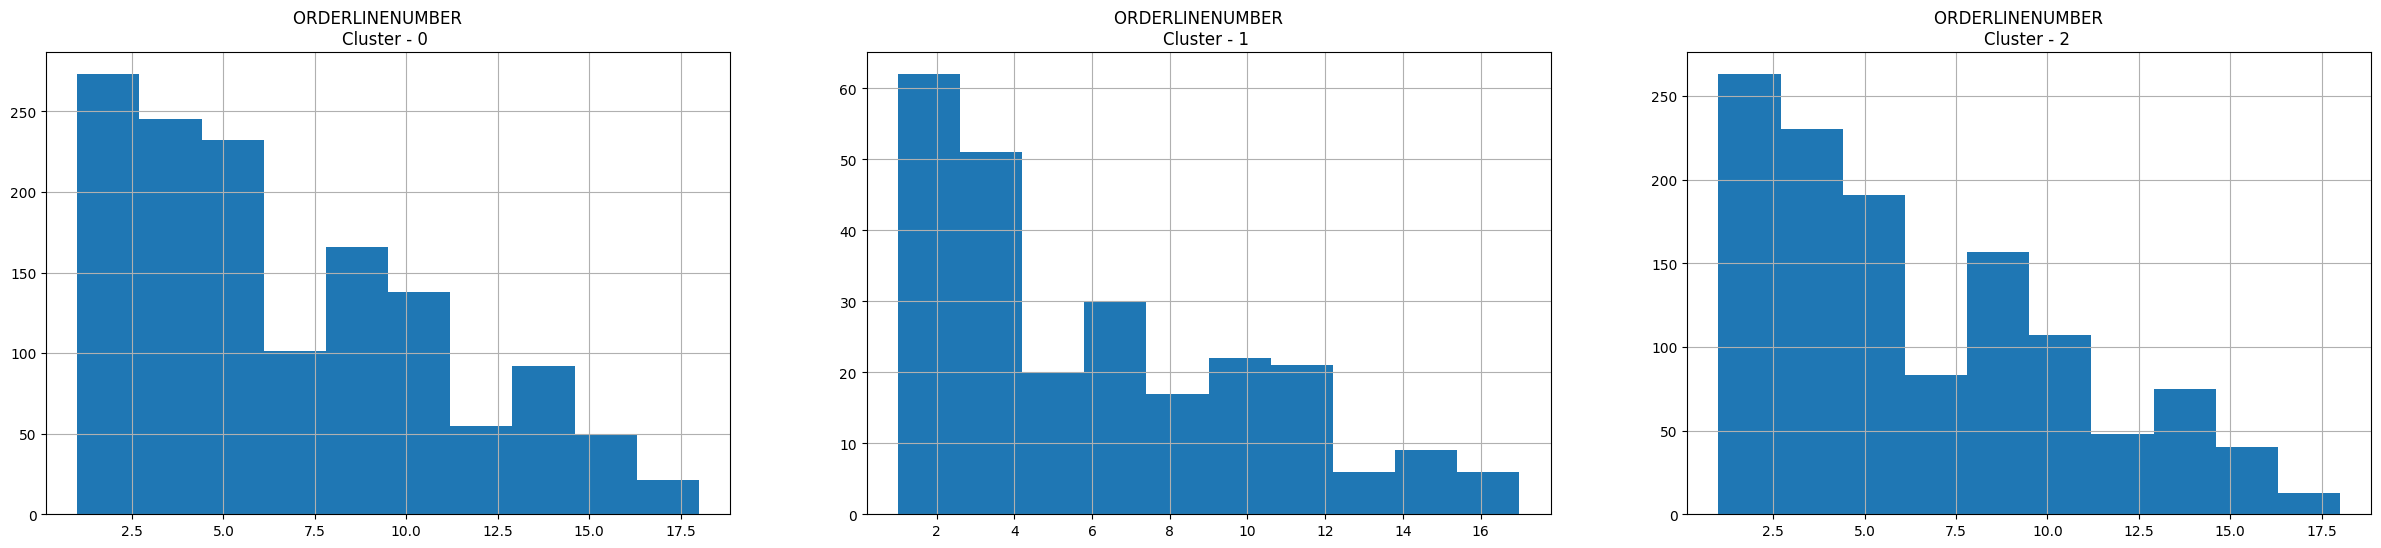

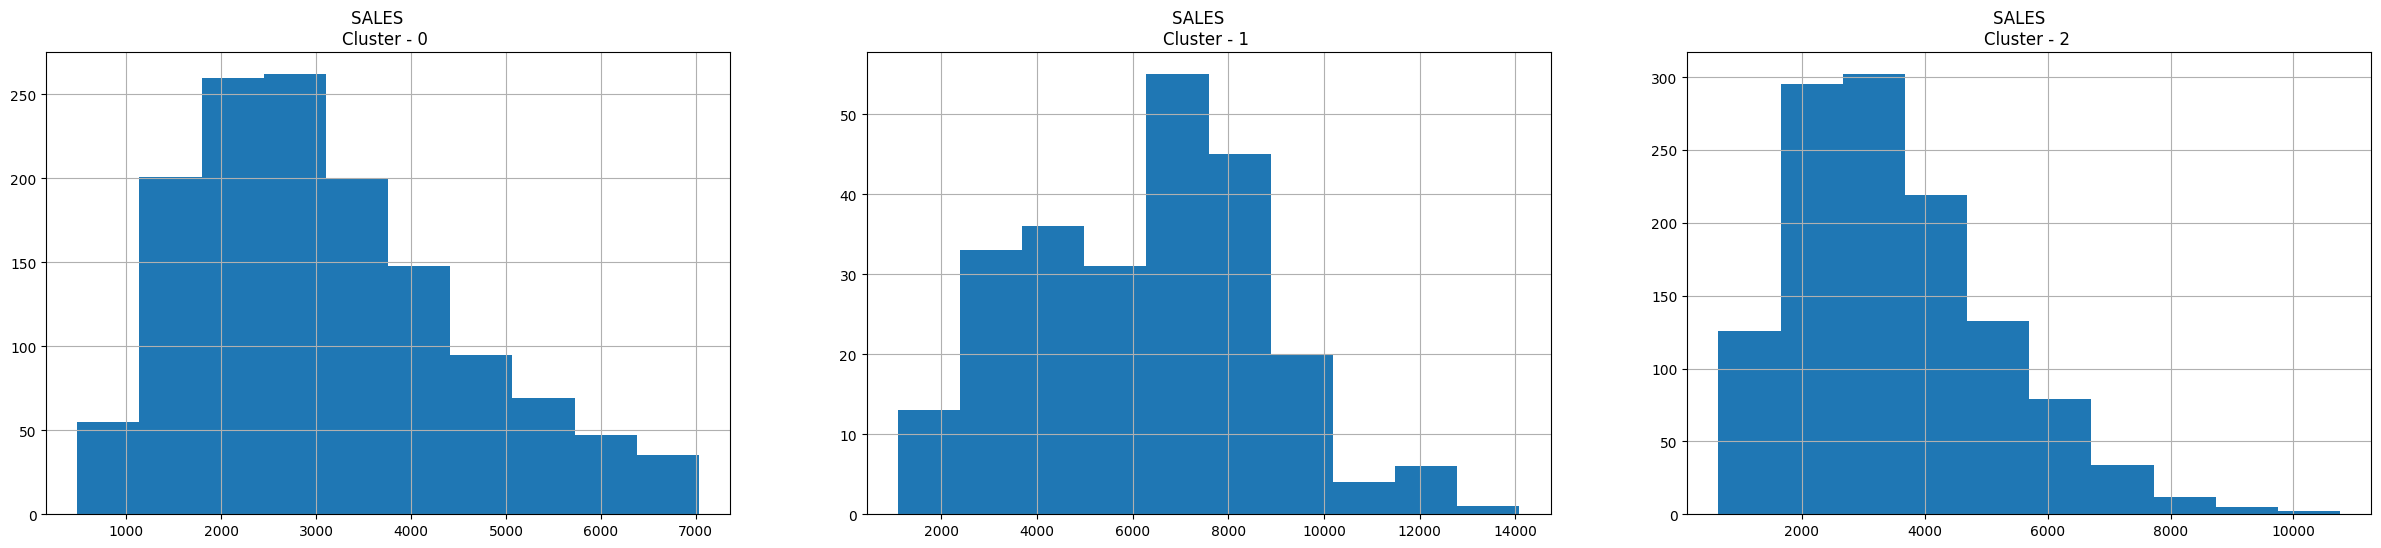

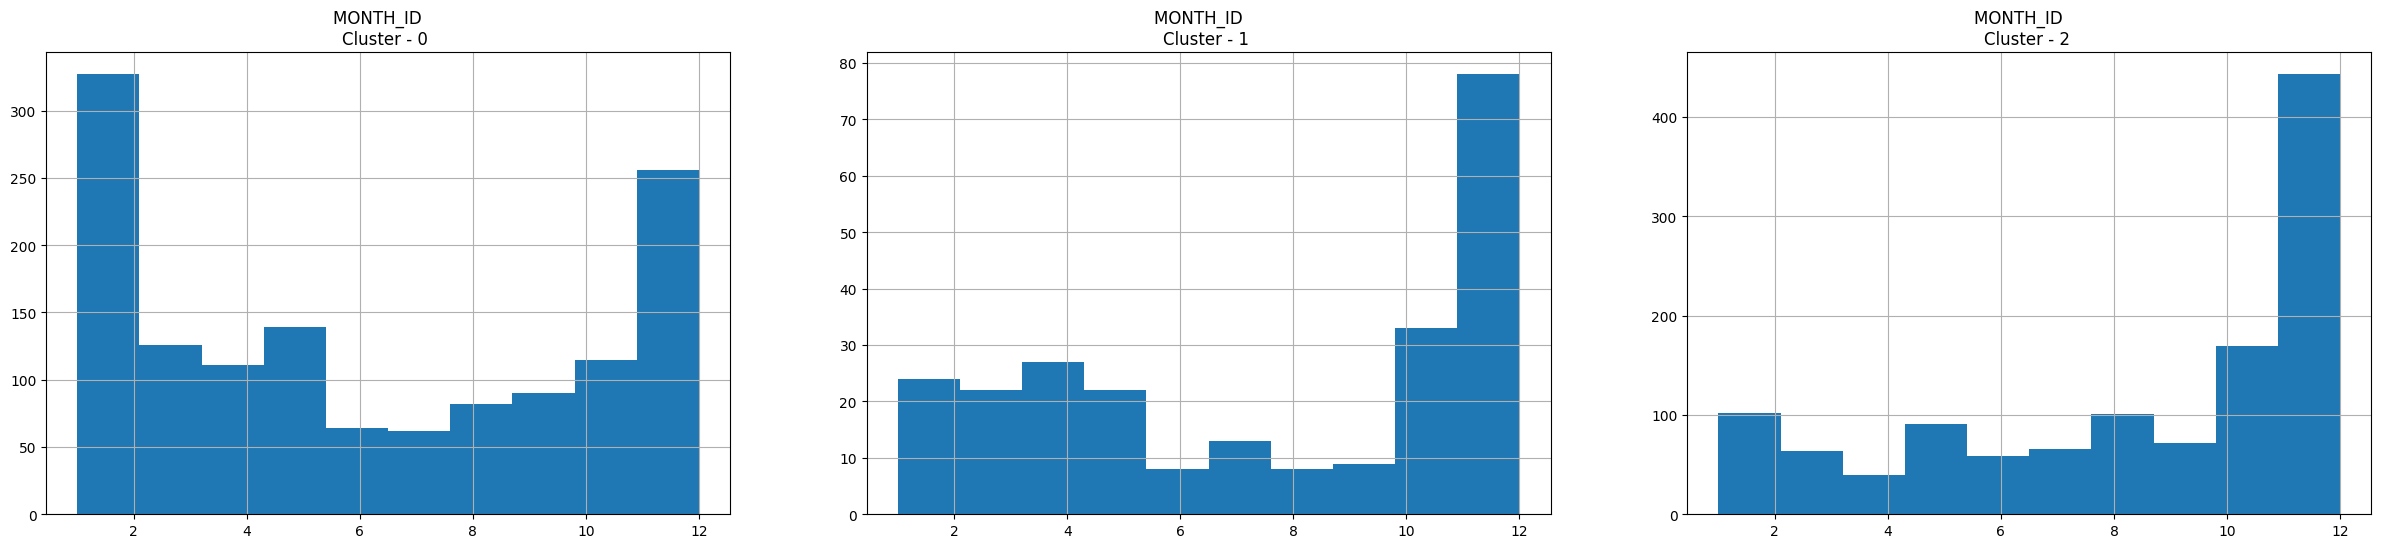

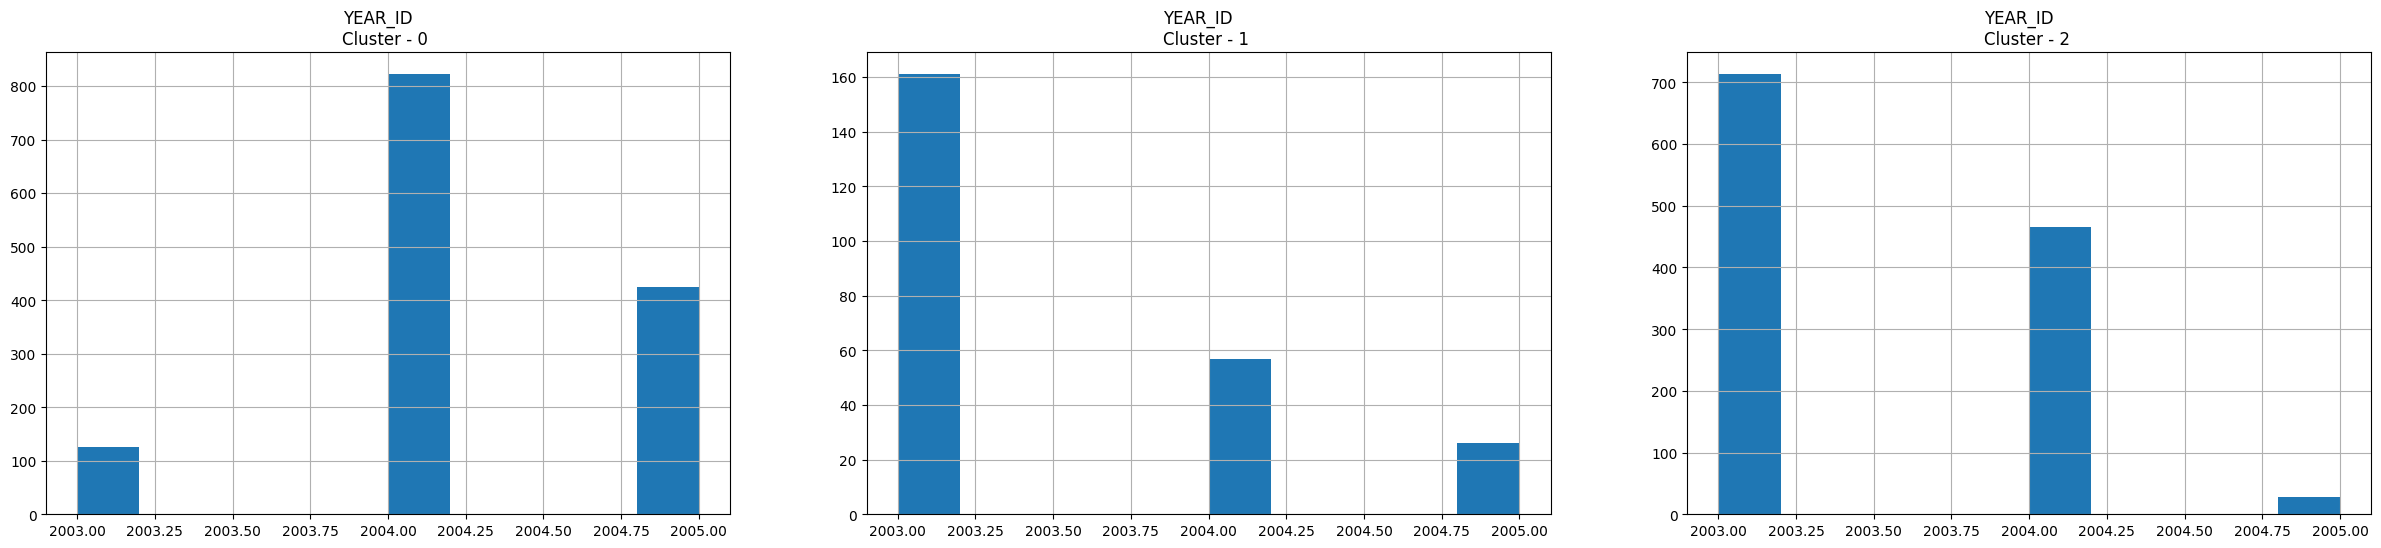

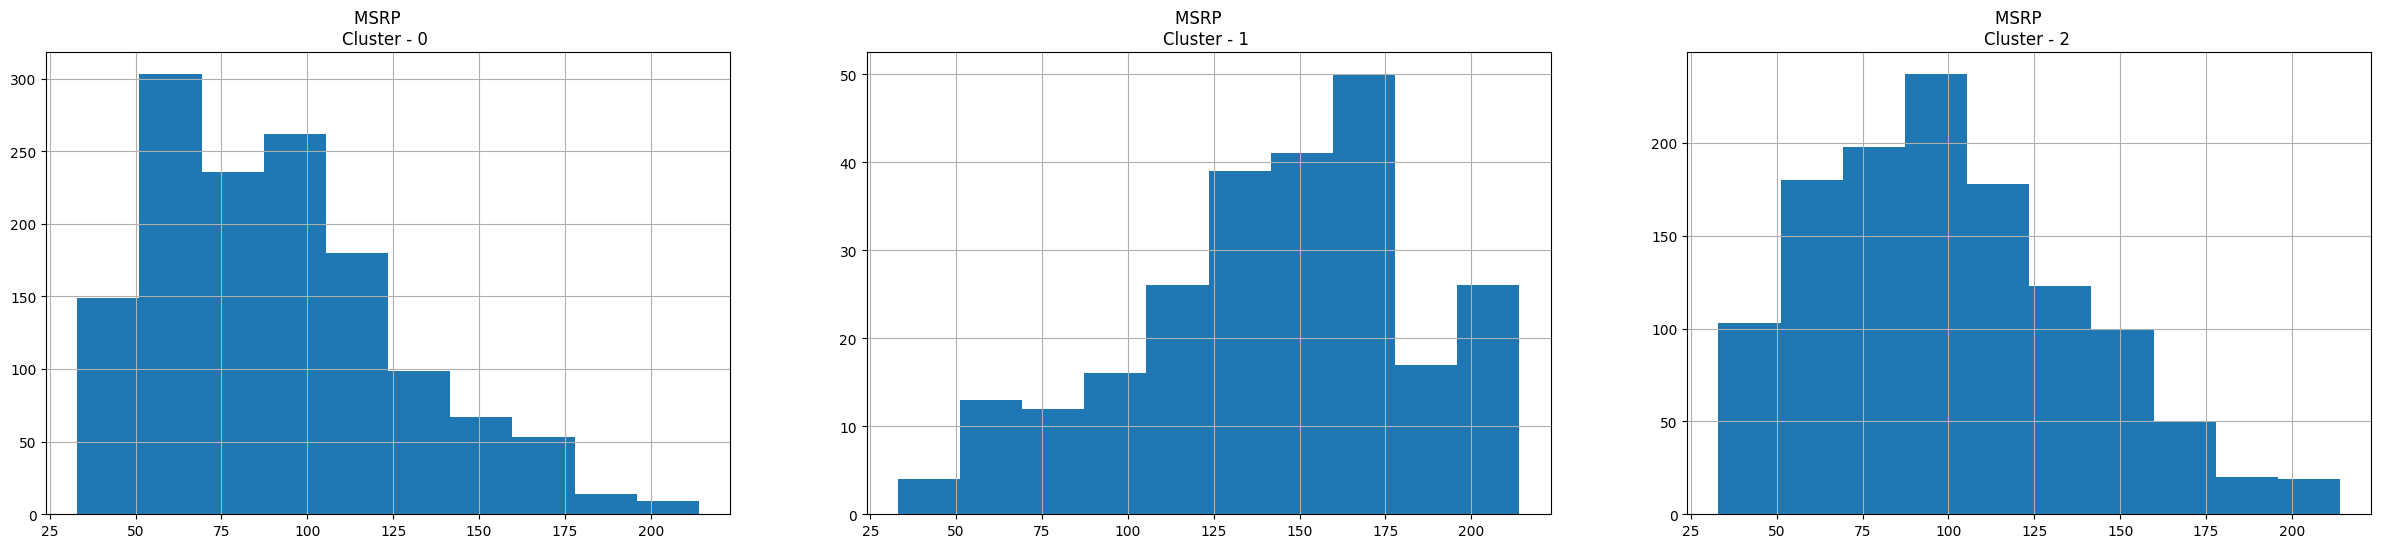

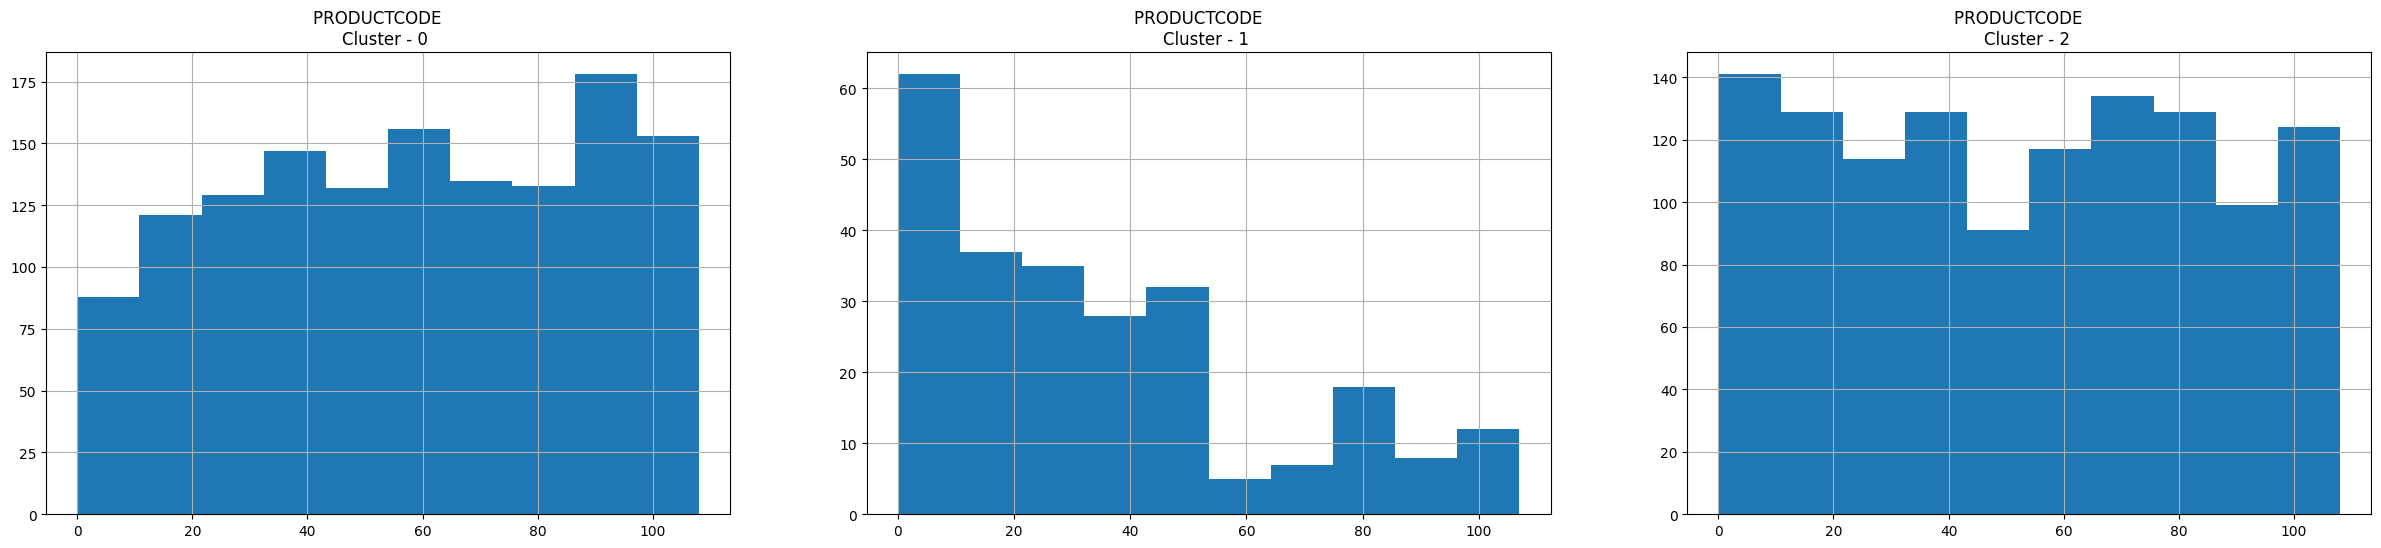

In [69]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()


# Cluster 0 - This group represents customers who buy items in high quantity(47), they usually buy items with high prices(99). They bring-in more sales than other clusters. They are mostly active through out the year. They usually buy products corresponding to product code 10-90. They buy products with high mrsp(158).
# Cluster 1 - This group represents customers who buy items in average quantity(37) and they buy tend to buy high price items(95). They bring-in average sales(4398) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-10 and 90-100.Also they prefer to buy products with high MSRP(115) .
# Cluster 2 - This group represents customers who buy items in small quantity(30), they tend to buy low price items(69). They correspond to the lowest total sale(2061) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-20 and 100-110  they then to buy products with low MSRP(77).

In [70]:
# Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486417,-1.181348,0.960386
1,-0.784658,-1.016114,1.426129
2,1.431547,0.123014,0.301763
3,1.288341,-0.209098,-0.628902
4,1.975836,-0.112841,-1.124139


In [71]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486417,-1.181348,0.960386,2
1,-0.784658,-1.016114,1.426129,2
2,1.431547,0.123014,0.301763,2
3,1.288341,-0.209098,-0.628902,2
4,1.975836,-0.112841,-1.124139,2


In [73]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 12, opacity = 0.8)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))